# Phase 4 — Extreme Value Analysis (EVT)

**Project:** Dynamic Financial Risk Modelling  
**Dataset:** S&P 500 Index (stooq.pl)  
**Time Span:** 2000–2025  

---

## Modeling Tail Risk in Financial Returns

While volatility models describe the dynamics of conditional variance, they do not fully characterize the behavior of **extreme market events**. Financial crises are driven by rare but severe shocks that lie in the tails of the return distribution.

This phase applies **Extreme Value Theory (EVT)** to model the tail behavior of S&P 500 log returns and quantify extreme risk measures such as Value-at-Risk (VaR) and Expected Shortfall (ES).

The analysis uses the **Peaks-Over-Threshold (POT)** framework with the **Generalized Pareto Distribution (GPD)**, which is asymptotically justified for modeling exceedances beyond high thresholds.

---

## Data Description

The analysis is based on daily log returns of the S&P 500 index, previously constructed in Phase 1 and analyzed under volatility models in Phase 3.

Let $r_t$ denote daily log returns. EVT focuses on the tail behavior of the distribution of $r_t$, particularly extreme negative returns associated with market crashes.

For risk management purposes, we focus on the **left tail** of the return distribution.

---

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto
from scipy.stats import norm

## Data Preparation for Extreme Value Analysis

This phase builds upon the processed log-return series constructed in Phase 1 and analyzed under volatility models in Phase 3.

Let $r_t$ denote the daily log returns of the S&P 500 index. Extreme Value Theory (EVT) focuses on the behavior of the **tails** of the return distribution, which correspond to rare but severe market events.

For risk management applications, we analyze the **left tail** of the return distribution, representing large negative returns (losses). These observations drive measures such as Value-at-Risk (VaR) and Expected Shortfall (ES).

The following dataset contains:
- Daily timestamps
- Corresponding log returns, computed as first differences of log prices

This series serves as the input for the Peaks-Over-Threshold (POT) analysis in subsequent sections.

In [2]:
# Load processed S&P 500 log returns
returns = pd.read_csv(
    "../data/processed/sp500_log_returns.csv",
    parse_dates=["Date"]
)

r = returns["log_return"].values

## Peaks-Over-Threshold (POT) Framework

Instead of modeling block maxima, the POT approach models all observations exceeding a sufficiently high threshold $u$.

For losses $L_t = -r_t$, exceedances are defined as:

$Y_t = L_t - u \mid L_t > u$

Under mild regularity conditions, the distribution of exceedances converges to the **Generalized Pareto Distribution (GPD)**.

A critical modeling choice is the threshold $u$, which must balance bias (too low) and variance (too high).

In [3]:
losses = -r

threshold = np.quantile(losses, 0.95)
exceedances = losses[losses > threshold] - threshold

len(exceedances)

327

### Threshold Selection and Tail Exceedances

We focus on extreme downside risk by transforming log returns into losses:

$L_t = -r_t$

A high quantile threshold is selected to define the tail region.
In this analysis, the 95th percentile of the loss distribution is used
as the threshold u.

Exceedances are defined as:

$Y_t = L_t - u for L_t > u$

This threshold yields 327 exceedances, providing a practical balance
between bias (threshold too low) and variance (threshold too high).

These exceedances form the empirical basis for fitting the
Generalized Pareto Distribution (GPD) in the next step.

---

## Mean Excess Plot

The mean excess function is defined as:

$e(u) = \mathbb{E}[L - u \mid L > u]$

For a GPD, the mean excess function is approximately linear above a valid threshold. This diagnostic helps validate the POT assumption.


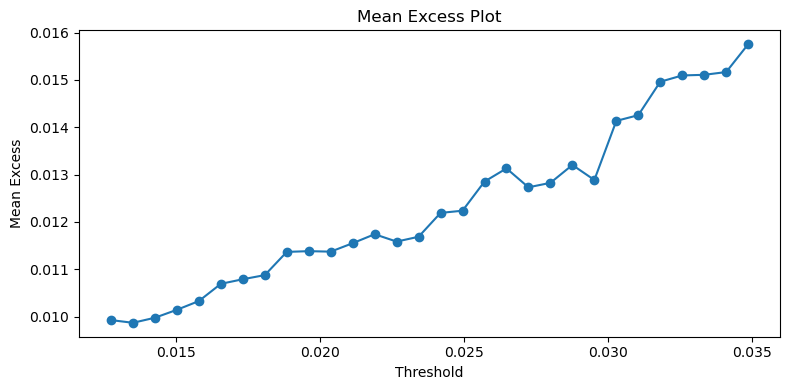

In [4]:
thresholds = np.linspace(
    np.quantile(losses, 0.90),
    np.quantile(losses, 0.99),
    30
)

mean_excess = [
    np.mean(losses[losses > u] - u) for u in thresholds
]

plt.figure(figsize=(8,4))
plt.plot(thresholds, mean_excess, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Mean Excess")
plt.title("Mean Excess Plot")
plt.tight_layout()
plt.show()

### Interpretation of the Mean Excess Plot

The mean excess function exhibits an approximately linear and increasing
pattern beyond the selected threshold region.

This behavior is consistent with the theoretical property of the
Generalized Pareto Distribution (GPD), supporting the validity of the
Peaks-Over-Threshold (POT) assumption for modeling extreme losses.

Minor fluctuations at lower thresholds reflect finite-sample variability,
while the stability at higher thresholds suggests that the chosen
quantile-based threshold provides an appropriate bias–variance trade-off.

Based on this diagnostic, the selected threshold is deemed suitable
for GPD fitting and tail risk estimation in subsequent analysis.

---

## Generalized Pareto Distribution Estimation

The GPD is characterized by:
- Shape parameter $\xi$ (tail index)
- Scale parameter $\beta$

The tail index governs the heaviness of the tail:
- $\xi > 0$: heavy-tailed (Pareto-type)
- $\xi = 0$: exponential tail
- $\xi < 0$: bounded tail


In [5]:
xi, loc, beta = genpareto.fit(exceedances, floc=0)

xi, beta

(0.18223245355338957, 0.009139449253316088)

### Interpretation of GPD Parameter Estimates

The estimated shape parameter (tail index) is positive, $\hat{\xi} > 0$, indicating **heavy-tailed behavior** in the distribution
of extreme losses.

This result implies that large negative returns occur with higher probability
than would be predicted under light-tailed (e.g., Gaussian) assumptions.
In particular, the presence of a Pareto-type tail suggests that extreme market
movements are not negligible and must be explicitly modeled.

The estimated scale parameter $\hat{\beta}$ governs the dispersion of
exceedances above the selected threshold and reflects the typical magnitude
of extreme losses once the threshold is breached.

Together, these estimates confirm that the tail of the return distribution
is sufficiently heavy to justify the use of Extreme Value Theory (EVT)
for risk quantification, motivating the subsequent estimation of
Value-at-Risk (VaR) and Expected Shortfall (ES) under a GPD framework.

---


## Extreme Risk Measures

Using Extreme Value Theory (EVT), Value-at-Risk (VaR) and Expected Shortfall (ES) can be extrapolated beyond observed quantiles, allowing characterization of rare but severe losses.

For confidence level $q$, under the Peaks-Over-Threshold (POT) framework with a Generalized Pareto Distribution (GPD):

$VaR_q = u + \frac{\beta}{\xi}
\left[
\left( \frac{1 - q}{p_u} \right)^{-\xi} - 1
\right]$

where $u$ is the threshold, $\beta$ is the scale parameter, $\xi$ is the shape parameter, and $p_u$ denotes the exceedance probability.

The corresponding Expected Shortfall (for $\xi < 1$) is given by:

$ES_q = \frac{VaR_q}{1 - \xi} + \frac{\beta - \xi u}{1 - \xi}$

Expected Shortfall represents the conditional expectation of losses exceeding the Value-at-Risk level and provides a coherent measure of tail risk severity.


In [9]:
q = 0.99
pu = np.mean(losses > threshold)

VaR_evt = threshold + (beta / xi) * (( (1 - q) / pu ) ** (-xi) - 1)
ES_evt = (VaR_evt / (1 - xi)) + ((beta - xi * threshold) / (1 - xi))

VaR_evt, ES_evt

(0.03578140111629205, 0.05077087117469818)

### Interpretation of EVT-Based Risk Measures

At the 99% confidence level, the EVT-based Value-at-Risk (VaR) estimate
($VaR_{0.99} \approx 3.58\%$) represents the loss threshold that is exceeded
with only 1% probability under the fitted GPD tail model.
This quantile characterizes the onset of extreme losses rather than their
severity.

The corresponding Expected Shortfall
($ES_{0.99} \approx 5.08\%$) measures the **average loss conditional on
exceeding the VaR level**, capturing the expected magnitude of tail events
once the extreme-loss regime is entered.
Because ES conditions on outcomes beyond the quantile, it provides a
coherent and more informative measure of tail risk than VaR alone.

The substantial gap between ES and VaR reflects the **heavy-tailed structure**
of the return distribution inferred by EVT.
Rather than clustering near the VaR threshold, extreme losses exhibit
meaningful escalation, indicating that tail events are both rare and severe.

Unlike empirical or Gaussian-based risk measures, EVT-based VaR and ES
explicitly extrapolate tail behavior beyond observed quantiles using a
parametric extreme-value framework.
As a result, these estimates are more reliable for assessing downside risk
under extreme market conditions, particularly during periods of elevated
volatility and systemic stress.

Overall, the EVT results highlight that risk in the far tail is not only a
matter of exceedance probability, but also of loss severity, reinforcing the
importance of tail-aware modeling in financial time-series analysis.

---

## Relation to Volatility Modeling (Phase 3)

This phase complements volatility modeling by focusing explicitly on
**extreme tail losses** rather than conditional variance dynamics.

While Phase 3 identifies periods of elevated market instability,
Extreme Value Theory quantifies the **severity of losses conditional on
those extreme states**.

Together, volatility models and EVT form a unified framework:
volatility models describe *when* risk intensifies,
and EVT quantifies *how severe* losses can become during those periods.

---

## Phase 4 Conclusion — Extreme Value Analysis

This phase focused on modeling **extreme downside risk** using Extreme Value Theory (EVT) under the Peaks-Over-Threshold (POT) framework.

The analysis confirmed that the tail of S&P 500 losses is **heavy-tailed**, as evidenced by a positive tail index (ξ > 0). This implies that extreme losses decay slowly and cannot be adequately captured by Gaussian assumptions.

By fitting a Generalized Pareto Distribution (GPD) to threshold exceedances, the model enabled:
- Extrapolation beyond observed quantiles
- Estimation of **Value-at-Risk (VaR)** at high confidence levels
- Estimation of **Expected Shortfall (ES)** as a coherent tail-risk measure

Compared to volatility models, EVT directly quantifies the **severity of rare market crashes**, rather than the variability of typical market movements. This distinction is crucial for stress testing and risk management under extreme conditions.

---

## Bridge to Phase 5 — Why Time–Frequency Analysis Comes Next

While EVT quantifies **how large extreme losses can be**, it remains **agnostic to temporal structure**.

Specifically, EVT does not explain:
- When extreme risk intensifies
- Whether tail risk is persistent or transient
- How volatility and dependence evolve across different time scales

Phase 5 addresses these limitations by introducing **time–frequency methods**, allowing risk dynamics to be studied simultaneously in time and frequency domains.

The outputs from Phases 3 and 4 (conditional volatility and tail risk measures) provide natural inputs for identifying:
- Regime shifts
- Structural breaks
- Frequency-dependent behavior during crises

This progression moves the analysis from *static tail estimation* to *dynamic, nonstationary risk decomposition*.

---

### Final EVT Risk Measures

The following calculations consolidate EVT-based Value-at-Risk (VaR) and
Expected Shortfall (ES) estimates at standard confidence levels for use in
later phases and documentation.

In [10]:
# Exceedance probability
pu = np.mean(losses > threshold)

def evt_var_es(q, threshold, beta, xi, pu):
    var_evt = threshold + (beta / xi) * (((1 - q) / pu) ** (-xi) - 1)
    es_evt = (var_evt + beta - xi * threshold) / (1 - xi)
    return var_evt, es_evt

# EVT VaR / ES at 95% and 99%
VaR_evt_95, ES_evt_95 = evt_var_es(0.95, threshold, beta, xi, pu)
VaR_evt_99, ES_evt_99 = evt_var_es(0.99, threshold, beta, xi, pu)

# Gaussian benchmark
mu = np.mean(losses)
sigma = np.std(losses)

def normal_var_es(q, mu, sigma):
    var = mu + sigma * norm.ppf(q)
    es = mu + sigma * norm.pdf(norm.ppf(q)) / (1 - q)
    return var, es

VaR_norm_95, ES_norm_95 = normal_var_es(0.95, mu, sigma)
VaR_norm_99, ES_norm_99 = normal_var_es(0.99, mu, sigma)

### Export Results

The following cell saves the final EVT and Gaussian benchmark risk measures
for reuse in later phases and reporting.

In [11]:
df_evt = pd.DataFrame({
    "confidence_level": [0.95, 0.99],
    "var_evt": [VaR_evt_95, VaR_evt_99],
    "es_evt": [ES_evt_95, ES_evt_99],
    "var_normal": [VaR_norm_95, VaR_norm_99],
    "es_normal": [ES_norm_95, ES_norm_99]
})

df_evt.to_csv(
    "../results/evt_var_es.csv",
    index=False
)

df_evt

,confidence_level,var_evt,es_evt,var_normal,es_normal
0,0.95,0.018683,0.029862,0.019865,0.024971
1,0.99,0.035781,0.050771,0.028193,0.032334


### Numerical Interpretation of EVT Risk Measures

The EVT-based Value-at-Risk (VaR) and Expected Shortfall (ES) estimates are
systematically larger than their Gaussian benchmark counterparts at both
confidence levels, reflecting the presence of heavy-tailed behavior in
equity market losses.

The divergence between EVT and Gaussian risk measures becomes more pronounced
at the 99% confidence level, indicating that tail risk is increasingly
underestimated under normality assumptions as one moves further into the
extreme tail.

Notably, EVT Expected Shortfall exceeds EVT VaR by a substantial margin,
highlighting the severity of losses conditional on extreme events. This
difference emphasizes the importance of ES as a coherent risk measure for
stress testing and downside risk assessment.

These numerical results corroborate the graphical diagnostics and tail
index estimates presented earlier, reinforcing the conclusion that extreme
downside risk in equity markets cannot be adequately captured using
light-tailed models.

---

**Status:** Phase 4 completed — tail risk quantified using EVT; results ready to be analyzed under time–frequency and nonstationary frameworks (Phase 5).